In [1]:
import dask.dataframe as dd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import dask.array as da
import os.path
import gc
from lmfit import Model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
folder = 'F:/data/restaurant'
input_path = folder+'/parquet'

In [3]:
df = dd.read_parquet(input_path)

# Restaurant OD network analysis
- For each type and date(year-month), draw the frequency-distribution plot. Power law analysis
- Group by date and self-loop (1 if county == place_county else 0), draw self-loop percentage chart
- Generate graph for each type and date (source=cbg, target=place_cbg). Calculate/plot network characteristics

In [4]:
types = df['Type'].unique().compute()

In [5]:
types

0           Mexican
1          American
2           Chinese
3           Italian
4        Vietnamese
5          Japanese
6             Mixed
7            Korean
8              Thai
9     Mediterranean
10           Indian
11          African
12    British/Irish
13       OtherAsian
14    MiddleEastern
15            Greek
16           German
17      AsianFusion
18        Caribbean
19         European
20    LatinAmerican
21          Spanish
22           French
Name: Type, dtype: object

In [6]:
dates = df['date'].unique().compute()

In [7]:
dates = dates.sort_values().reset_index(drop=True)

In [8]:
dates

0     2019-01
1     2019-02
2     2019-03
3     2019-04
4     2019-05
5     2019-06
6     2019-07
7     2019-08
8     2019-09
9     2019-10
10    2019-11
11    2019-12
12    2020-01
13    2020-02
14    2020-03
15    2020-04
16    2020-05
17    2020-06
18    2020-07
19    2020-08
20    2020-09
21    2020-10
22    2020-11
23    2020-12
24    2021-01
25    2021-02
26    2021-03
27    2021-04
28    2021-05
29    2021-06
30    2021-07
31    2021-08
32    2021-09
33    2021-10
34    2021-11
35    2021-12
Name: date, dtype: object

In [9]:
#  The raw data has each row reprensenting the visitation from one block to one placekey for each month
series_type_d = df.groupby(['Type', 'date', 'visitation']).placekey.count().compute()

In [10]:
df_type_d = series_type_d.to_frame()
df_type_d = df_type_d.reset_index(level=[1,2,])

# National leve visitation frequency plot

In [11]:
three_year_palette = sns.color_palette(sns.color_palette("flare", n_colors=len(dates)//3) + sns.color_palette("ch:s=.25,rot=-.25", n_colors=len(dates)//3) + sns.light_palette("seagreen", n_colors=len(dates)//3))

In [12]:
def draw_frequency_replot(df_d, show_ticks=False, save_path=None, show_legend=True):
    sns.set_theme(style="ticks", font_scale=1.5, font="Arial")
    sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

    g = sns.relplot(
        data=df_d,
        x="visitation", y="placekey", col=df_d.index, hue="date",
        palette=three_year_palette, marker="$\circ$", ec="face", s=100,
        col_wrap=4, height=6, aspect=2, facet_kws={'legend_out': True}
    )

    if show_legend:
        g._legend.set_title("Date")
    else:
        g._legend.remove()

    for t, ax in g.axes_dict.items():
        ax.text(.1, .1, t, transform=ax.transAxes, fontweight="bold", fontsize="large")
        ax.set_xscale('log')
        ax.set_yscale('log')

    if not show_ticks:
        g.set(xticklabels=[])
        g.set(yticklabels=[])

    # Tweak the supporting aspects of the plot
    g.set_titles("")
    g.set_axis_labels("", "")
    
    g.tight_layout(pad=0.1)
    
    if save_path != None:
        g.savefig(save_path)

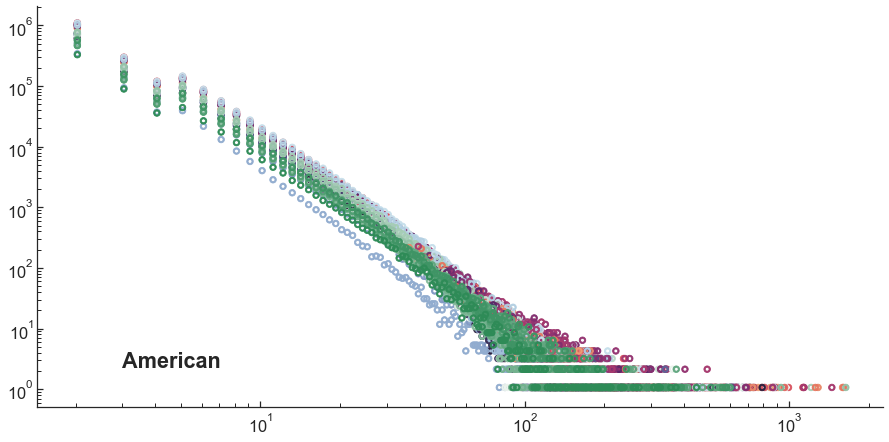

In [13]:
draw_frequency_replot(df_type_d[df_type_d.index=='American'], show_ticks=True, save_path=folder+"/by_type_visitation_frequency_ticks.png", show_legend=False)

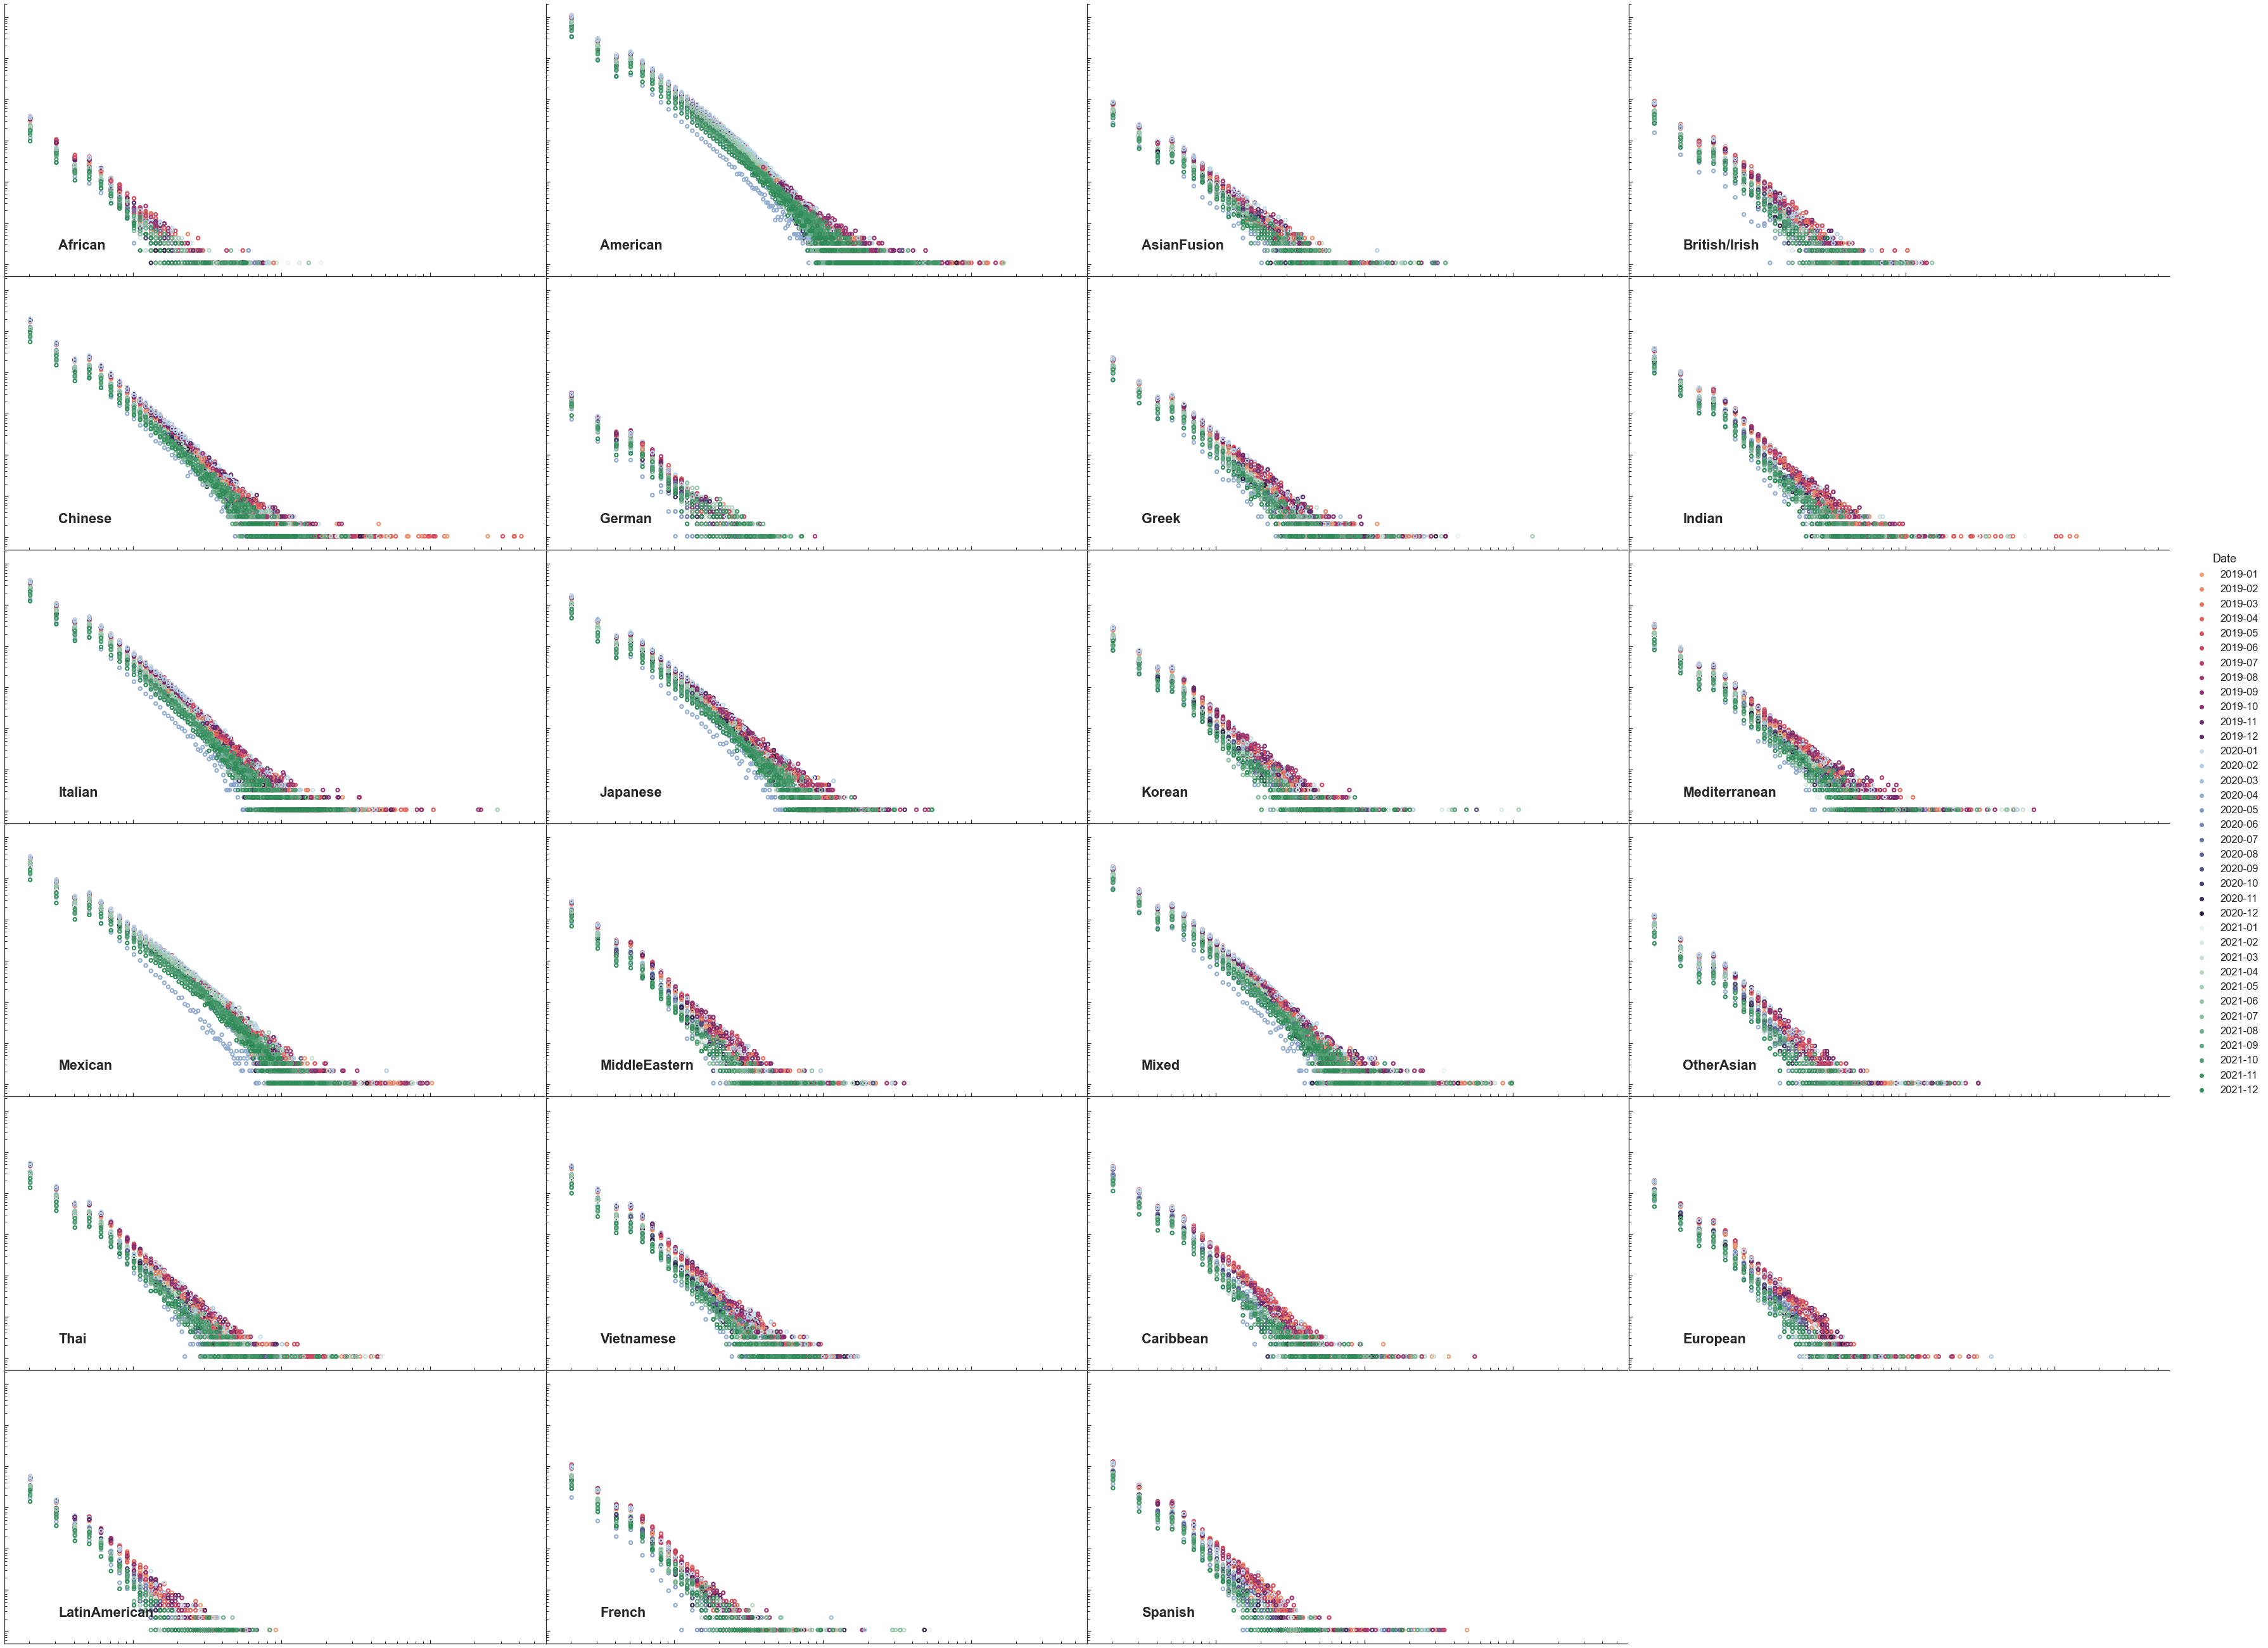

In [14]:
df_type_d.to_csv(folder+"/by_type_visitation_frequency.csv")
draw_frequency_replot(df_type_d, save_path=folder+"/by_type_visitation_frequency.png")

# Distance decay
- Use bins with distance
- discard the first bin
- Calculate alpha
- Use Three color ramps for three years, Hollow (prevent drawing orders)
- 20 MSAs all types (distance decay affected by location)
- all type united states (distance decay affected by type)

In [15]:
df_exclude_bin0 = df[df['distance_bin_100']!=0] # 0 is the special category to represent the first bin/category

In [16]:
df_exclude_bin0.head()

placekey  visitation  month  year          cbg       tract  \
3991  222-222@3bt-br8-rff           2      1  2019  20200001022  2020000102   
3992  222-222@3bt-br8-rff           2      1  2019  21700013004  2170001300   
3993  222-222@3bt-br8-rff           2      1  2019  20200009022  2020000902   
3994  222-222@3bt-br8-rff           2      1  2019  20200004001  2020000400   
3995  222-222@3bt-br8-rff           2      1  2019  20200008022  2020000802   

      county  state     date  place_county  ...        Lat         Lon  \
3991    2020      2  2019-01          2020  ...  61.222034 -149.779144   
3992    2170      2  2019-01          2020  ...  61.222034 -149.779144   
3993    2020      2  2019-01          2020  ...  61.222034 -149.779144   
3994    2020      2  2019-01          2020  ...  61.222034 -149.779144   
3995    2020      2  2019-01          2020  ...  61.222034 -149.779144   

                    source_msa  self_loop self_loop_county  place_cbg_str  \
3991  Anchorage, AK Metro Area          0                1   020200008013   
3992  Anchorage, AK Metro Area          0                0   020200008013   
3993  Anchorage, AK Metro Area          0                1   020200008013   
3994  Anchorage, AK Metro Area          0                1   020200008013   
3995  Anchorage, AK Metro Area          0                1   020200008013   

           cbg_str       distance  distance_bin_100_cat  distance_bin_100  
3991  020200001022   51043.738885          49436.045195      49436.045195  
3992  021700013004  108535.475968         108758.578473     108758.578473  
3993  020200009022    9352.345709           9887.689676       9887.689676  
3994  020200004001   12237.192922          13842.525228      13842.525228  
3995  020200008022    4505.007949           5932.854124       5932.854124  

[5 rows x 25 columns]

In [17]:
df_msa20_exclude_bin0 = df_exclude_bin0[df_exclude_bin0['is_top20']==1]
df_msa20 = df[df['is_top20']==1]

In [18]:
msa_top20 = df_msa20['MSAnamelsad'].unique().compute()
msa_top20 = msa_top20.sort_values().reset_index(drop=True)

In [19]:
msa_top20

0       Atlanta-Sandy Springs-Alpharetta, GA Metro Area
1              Baltimore-Columbia-Towson, MD Metro Area
2             Boston-Cambridge-Newton, MA-NH Metro Area
3         Chicago-Naperville-Elgin, IL-IN-WI Metro Area
4            Dallas-Fort Worth-Arlington, TX Metro Area
5                 Denver-Aurora-Lakewood, CO Metro Area
6                Detroit-Warren-Dearborn, MI Metro Area
7       Houston-The Woodlands-Sugar Land, TX Metro Area
8         Los Angeles-Long Beach-Anaheim, CA Metro Area
9     Miami-Fort Lauderdale-Pompano Beach, FL Metro ...
10    Minneapolis-St. Paul-Bloomington, MN-WI Metro ...
11     New York-Newark-Jersey City, NY-NJ-PA Metro Area
12    Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Me...
13                 Phoenix-Mesa-Chandler, AZ Metro Area
14      Riverside-San Bernardino-Ontario, CA Metro Area
15        San Diego-Chula Vista-Carlsbad, CA Metro Area
16        San Francisco-Oakland-Berkeley, CA Metro Area
17               Seattle-Tacoma-Bellevue, WA Met

In [20]:
type_top5 = ['American', 'Chinese', 'Mexican', 'Italian', 'Japanese']

- Question: for the log of visitation, take the log before taking the sum over each bin, or after? and also the division before taking the total sum or after
- Use the following:
 - take the sum of each bin
 - calculate the probability: one bin sum / total sum
 - use plotting function to set the log scale (interally deal with negative infinity by cutting)

In [21]:
df_msa20_bymsa_exclude_bin0 = df_msa20_exclude_bin0.groupby(['MSAnamelsad', 'date', 'distance_bin_100'])['visitation'].sum().compute().to_frame()
df_msa20_bymsa_prob_exclude_bin0 = df_msa20_bymsa_exclude_bin0.groupby(level=[0,1]).apply(lambda x: x / float(x.sum()))
df_msa20_bymsa_prob_exclude_bin0 = df_msa20_bymsa_prob_exclude_bin0.reset_index()

In [22]:
df_msa20_bymsa_exclude_bin0

visitation
MSAnamelsad                                        date    distance_bin_100            
Minneapolis-St. Paul-Bloomington, MN-WI Metro Area 2019-01 5932.854124            22804
                                                           9887.689676            17293
                                                           13842.525228           12272
                                                           17797.360780            8510
                                                           21752.196331            8143
...                                                                                 ...
Phoenix-Mesa-Chandler, AZ Metro Area               2021-12 85029.565162               3
Riverside-San Bernardino-Ontario, CA Metro Area    2021-12 108758.578473              2
                                                           132487.591784              3
Tampa-St. Petersburg-Clearwater, FL Metro Area     2021-12 104803.742921              5
Washington-Arlington-Alexandria, DC-VA-MD-WV Me... 2021-12 148306.933992              2

[32216 rows x 1 columns]

In [23]:
def draw_distribution_replot(df_d, col, show_ticks=False, save_path=None, show_legend=True):
    sns.set_theme(style="ticks", font_scale=1.5, font="Arial")
    sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
    #sns.set(font_scale=1.5) # this changes all the style, should be put in different place
    g = sns.relplot(
        data=df_d,
        x="distance_bin_100", y="visitation", col=col, hue="date",
        palette=three_year_palette, marker="$\circ$", ec="face", s=100,
        col_wrap=4, height=6, aspect=2, facet_kws={'legend_out': True}
    )
    
    if show_legend:
        g._legend.set_title("Date")
    else:
        g._legend.remove()
    
    for t, ax in g.axes_dict.items():
        ax.text(.1, .1, t, transform=ax.transAxes, fontweight="bold", fontsize="large")
        #ax.tick_params(axis='x', rotation=45)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        ax.set_xticks([5*1000, 10*1000, 20*1000, 50*1000, 100*1000, 200*1000, 300*1000])
        
        if show_ticks:
            ax.set_xticklabels(['5km', '10km', '20km', '50km', '100km', '200km', '300km'])
    
    if not show_ticks:
        g.set(xticklabels=[])
        g.set(yticklabels=[])

    # Tweak the supporting aspects of the plot
    g.set_titles("")
    g.set_axis_labels("", "")
    
    g.tight_layout(pad=0.1)
    
    if save_path != None:
        g.savefig(save_path)

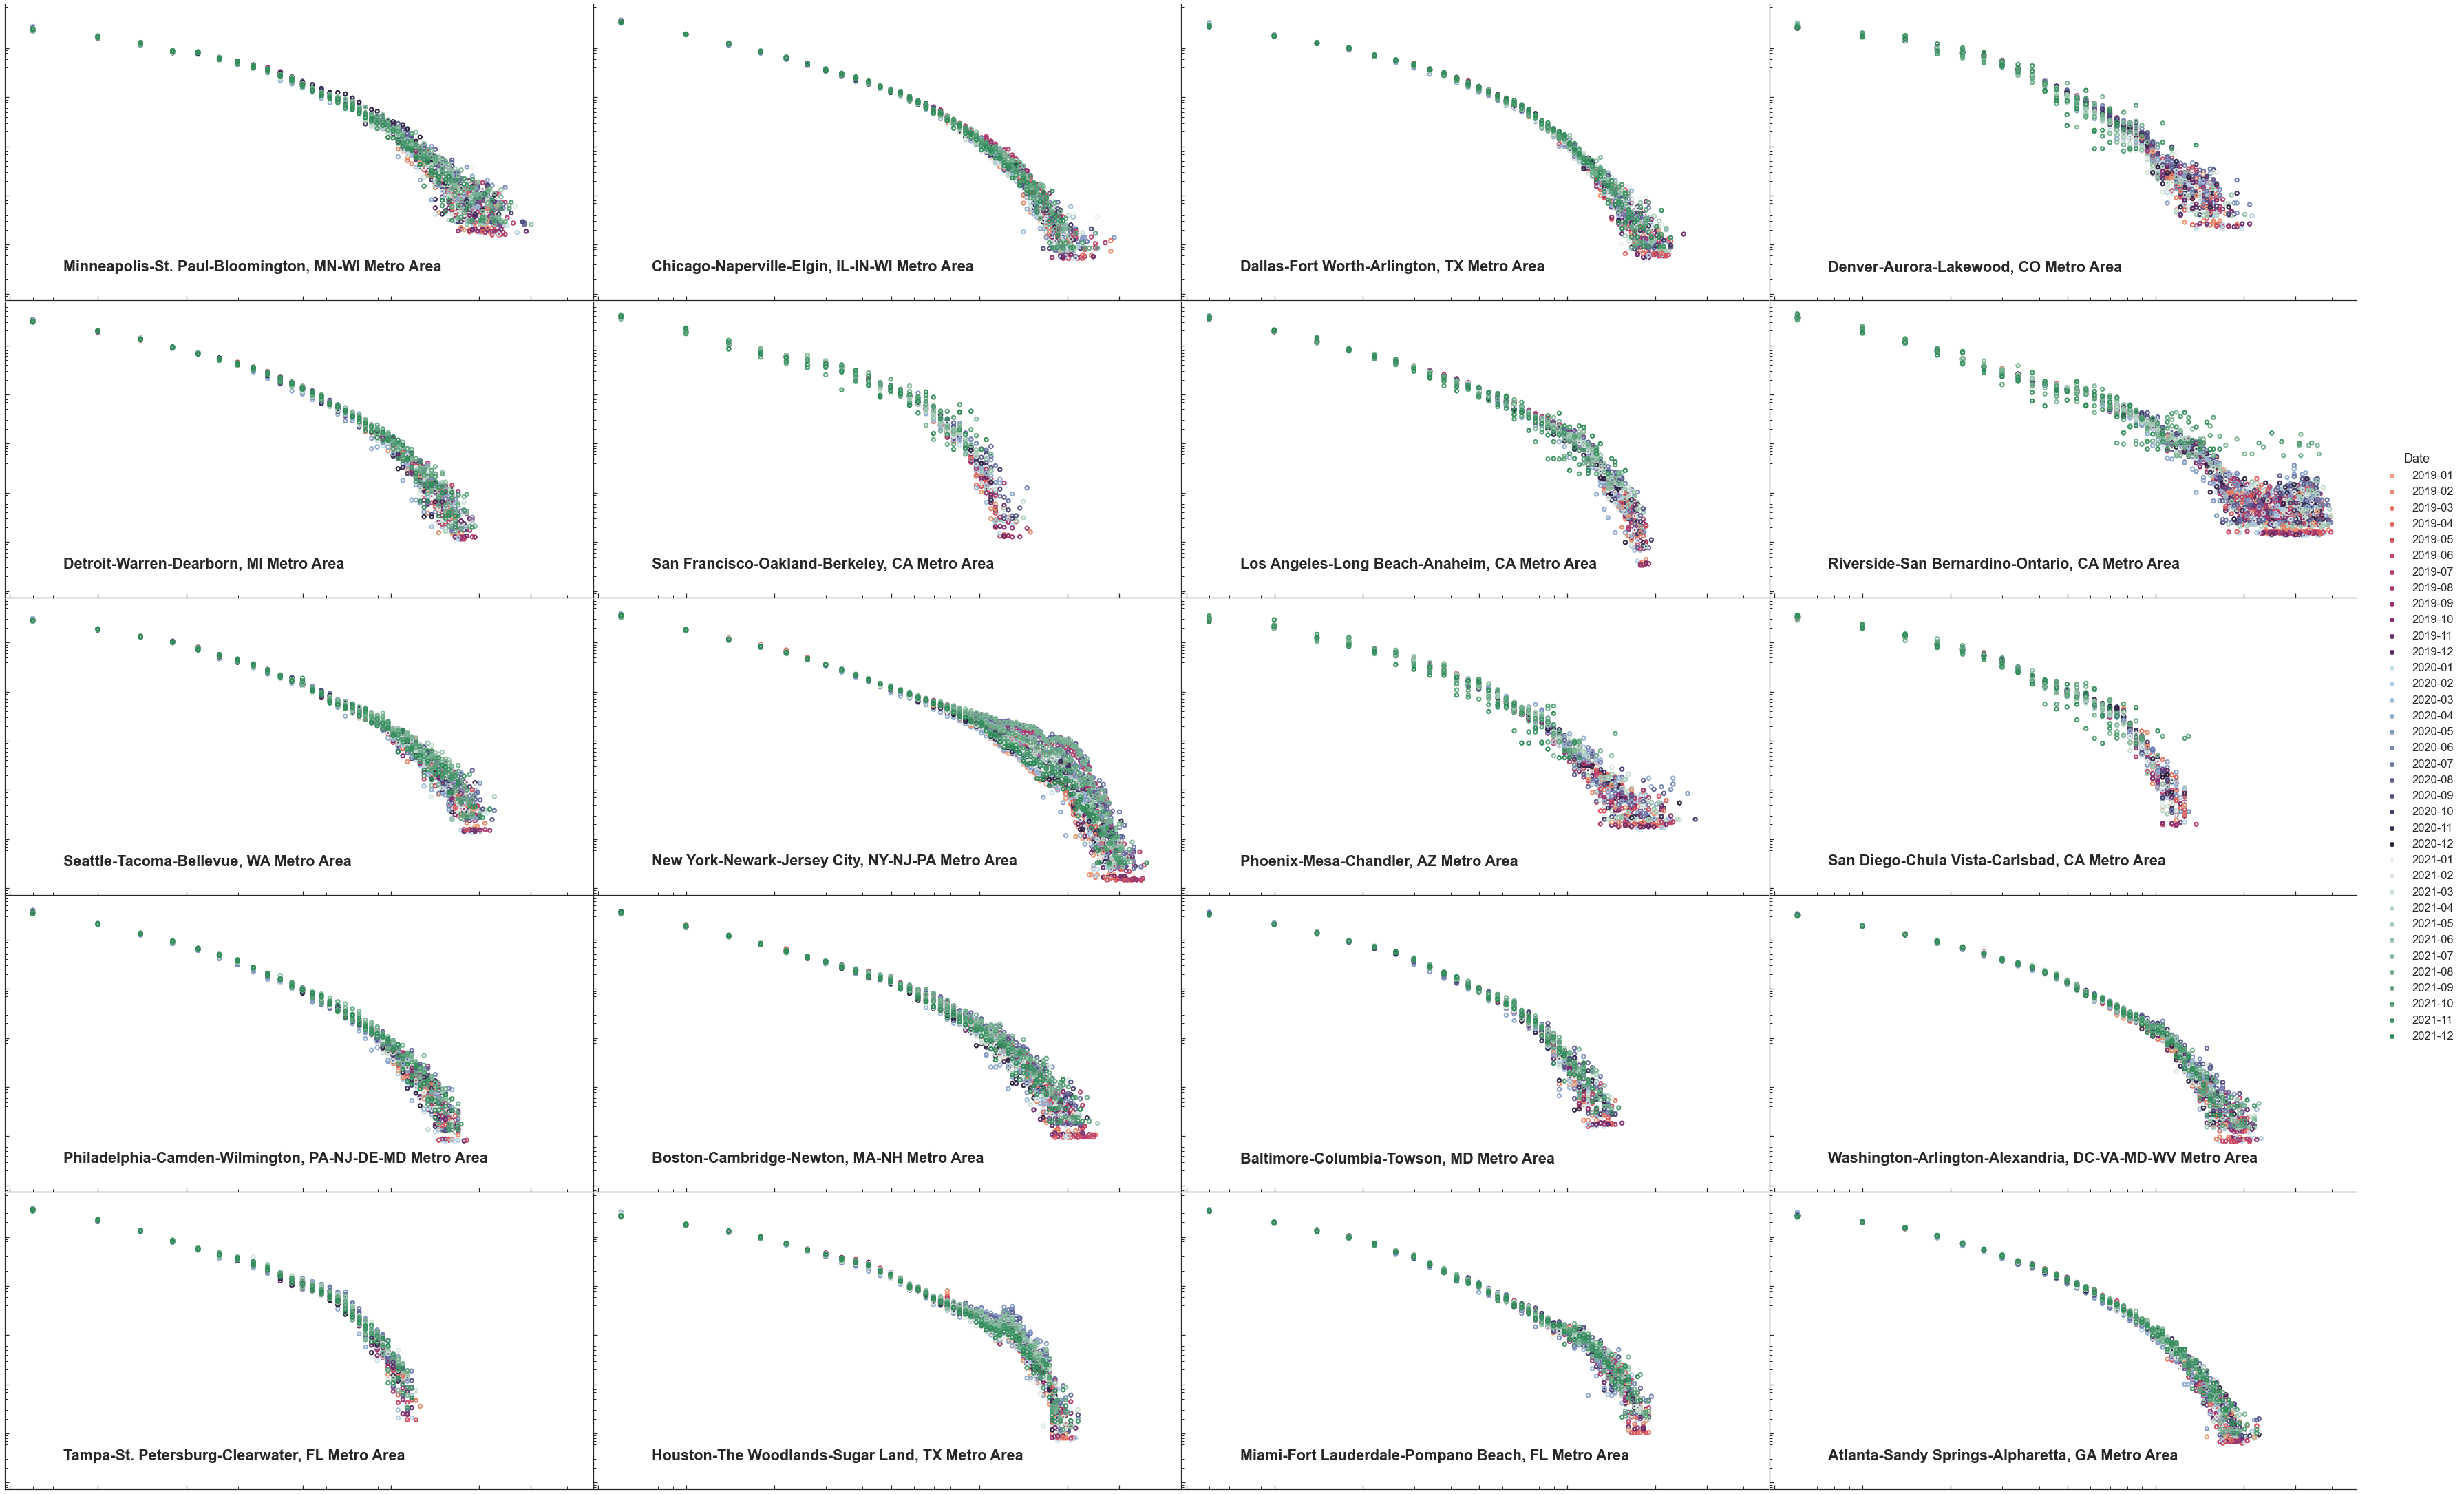

In [24]:
df_msa20_bymsa_prob_exclude_bin0.to_csv(folder+'/by_msa_all_types_distance_decay.csv')
draw_distribution_replot(df_msa20_bymsa_prob_exclude_bin0, 'MSAnamelsad', save_path=folder+'/by_msa_all_types_distance_decay.png')

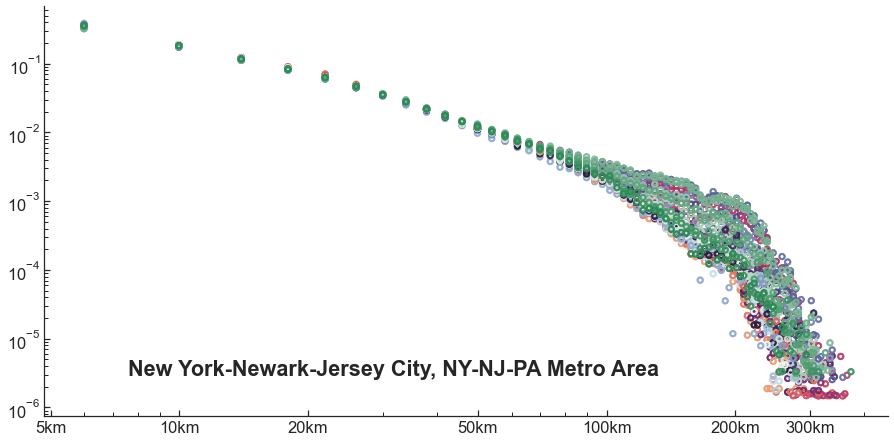

In [25]:
draw_distribution_replot(df_msa20_bymsa_prob_exclude_bin0[df_msa20_bymsa_prob_exclude_bin0['MSAnamelsad']=='New York-Newark-Jersey City, NY-NJ-PA Metro Area'], 'MSAnamelsad', show_ticks=True, save_path=folder+'/by_msa_all_types_distance_decay_ticks.png', show_legend=False)

In [26]:
df_bytype_exclude_bin0 = df_exclude_bin0.groupby(['Type', 'date', 'distance_bin_100'])['visitation'].sum().compute().to_frame()
df_bytype_prob_exclude_bin0 = df_bytype_exclude_bin0.groupby(level=[0,1]).apply(lambda x: x / float(x.sum()))
df_bytype_prob_exclude_bin0 = df_bytype_prob_exclude_bin0.reset_index()

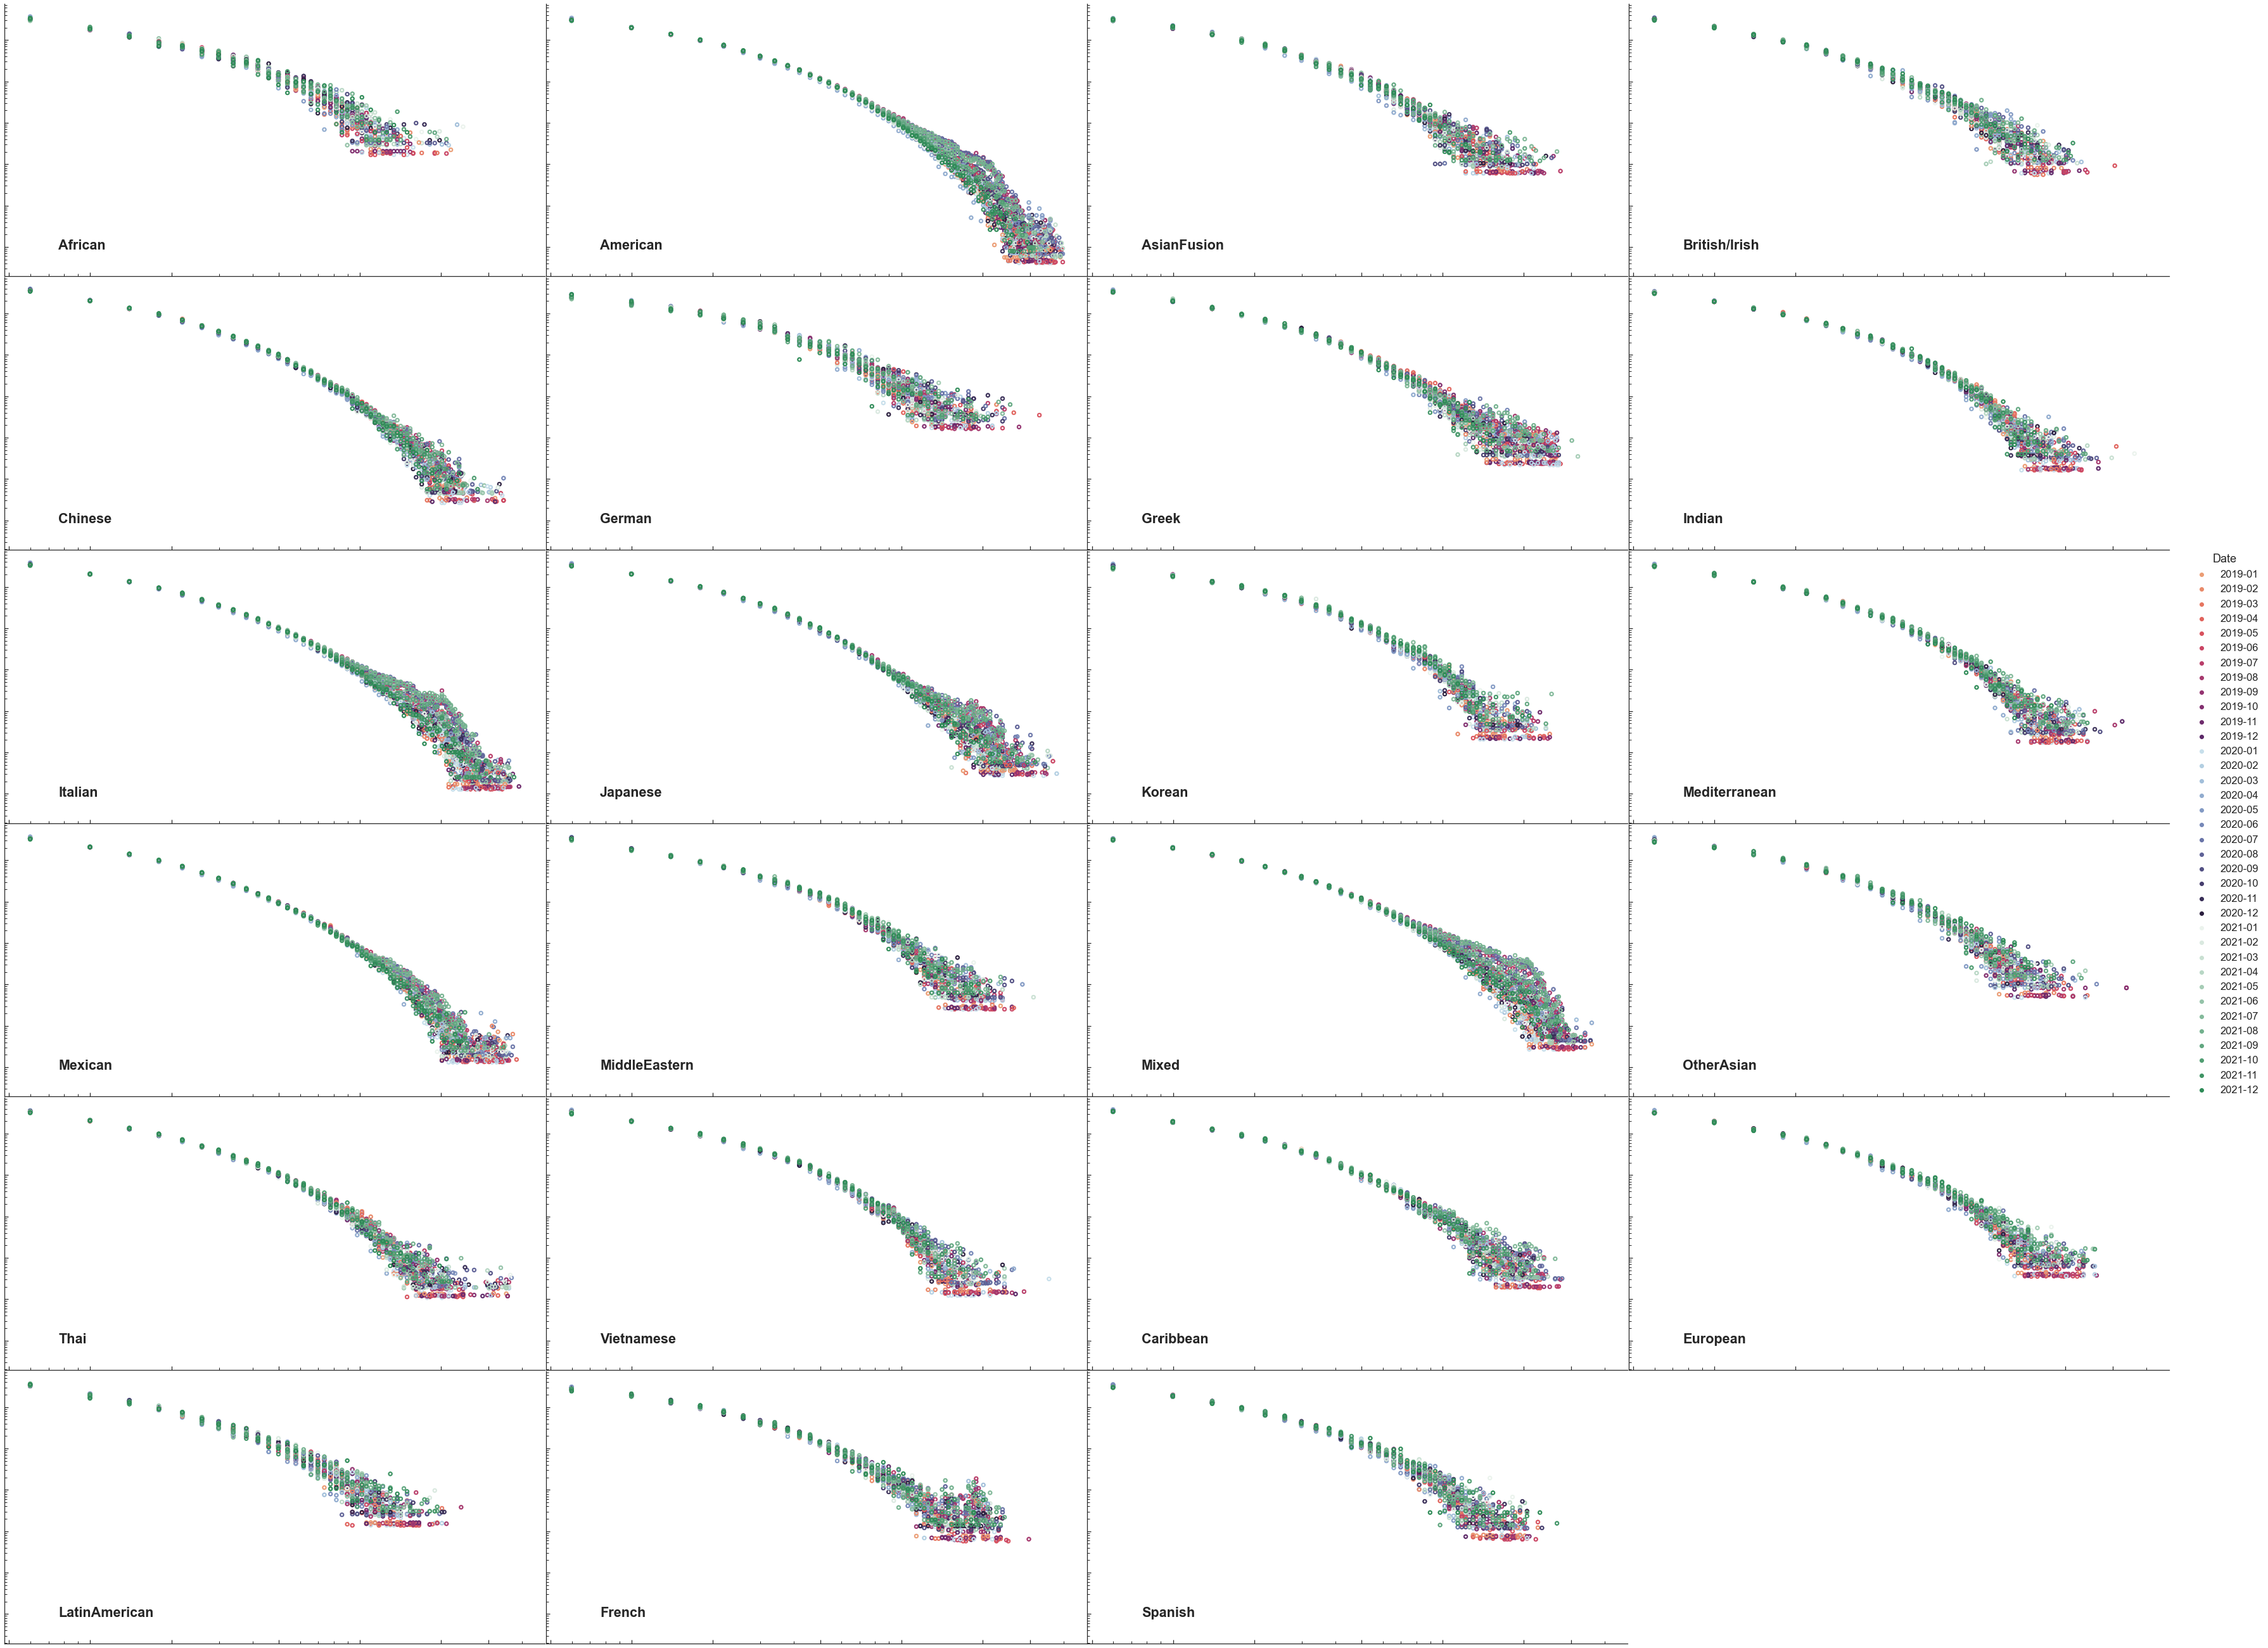

In [27]:
df_bytype_prob_exclude_bin0.to_csv(folder+'/by_type_us_distance_decay.csv')
draw_distribution_replot(df_bytype_prob_exclude_bin0, 'Type', save_path=folder+'/by_type_us_distance_decay.png')

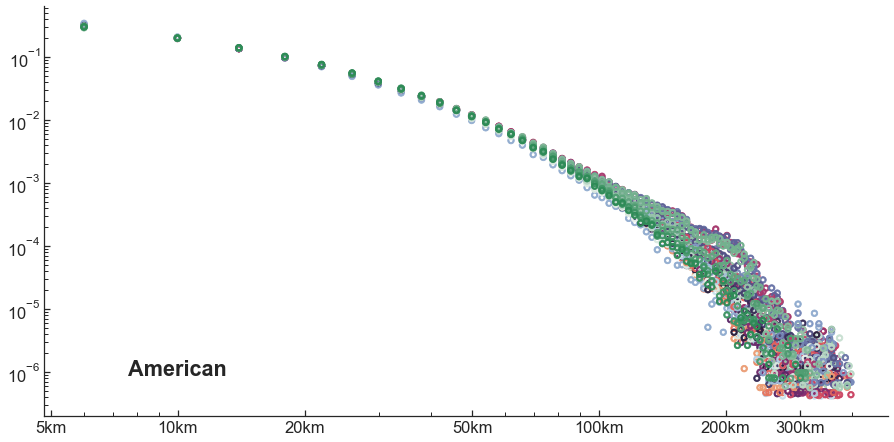

In [28]:
draw_distribution_replot(df_bytype_prob_exclude_bin0[df_bytype_prob_exclude_bin0['Type']=='American'], 'Type', show_ticks=True, save_path=folder+'/by_type_us_distance_decay_ticks.png', show_legend=False)

In [29]:
def powerlaw(x, k, a):
    return k*pow(x, -a)

def exponential(x, k, a):
    return k * np.exp(x*(-a))

In [30]:
def fit_by_date(df_by_dates, dates, categories, category_field, date_field="date", x_field="distance_bin_100", y_field="visitation"):
    res = []
    for c in categories:
        df_c = df_by_dates.loc[df_by_dates[category_field]==c]
        for d in dates:
            df_cd = df_c.loc[df_c[date_field]==d]
            df_cd = df_cd.sort_values(by=x_field)
            
            row = {}
            row['category'] = c
            row['date'] = d
            
            m1res = Model(powerlaw).fit(df_cd[y_field], x=df_cd[x_field], k=0.1, a=0.6, method='leastsq')
            row['powerlaw_a'] = m1res.params['a'].value
            
            m2res = Model(exponential).fit(df_cd[y_field], x=df_cd[x_field], k=0.08, a=0.00003, method='leastsq')
            row['exponential_a'] = m2res.params['a'].value
            
            res.append(row)
        
    return pd.DataFrame.from_dict(res)

In [31]:
df_fit_bymsa = fit_by_date(df_msa20_bymsa_prob_exclude_bin0, dates, msa_top20, 'MSAnamelsad')

In [32]:
df_fit_bytype = fit_by_date(df_bytype_prob_exclude_bin0, dates, types, 'Type')

In [33]:
def draw_fit_replot(df_fit, y_field,  yaxis_label, title=None, save_path=None):
    sns.set_theme(style="ticks", font_scale=1.5, font="Arial")
    sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
    
    f, ax = plt.subplots(figsize=(30, 21))
    g = sns.lineplot(
        data=df_fit,
        x="date", y=y_field, hue="category", style="category",
        palette="pastel", linewidth=2, zorder=5, markers=True, markersize=12, ax=ax
    )
    
    ax.tick_params(axis='x', rotation=45)
    ax.set(xlabel='Date', ylabel=yaxis_label)
    leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=2)
    
    if save_path != None:
        f.savefig(save_path, bbox_inches='tight')

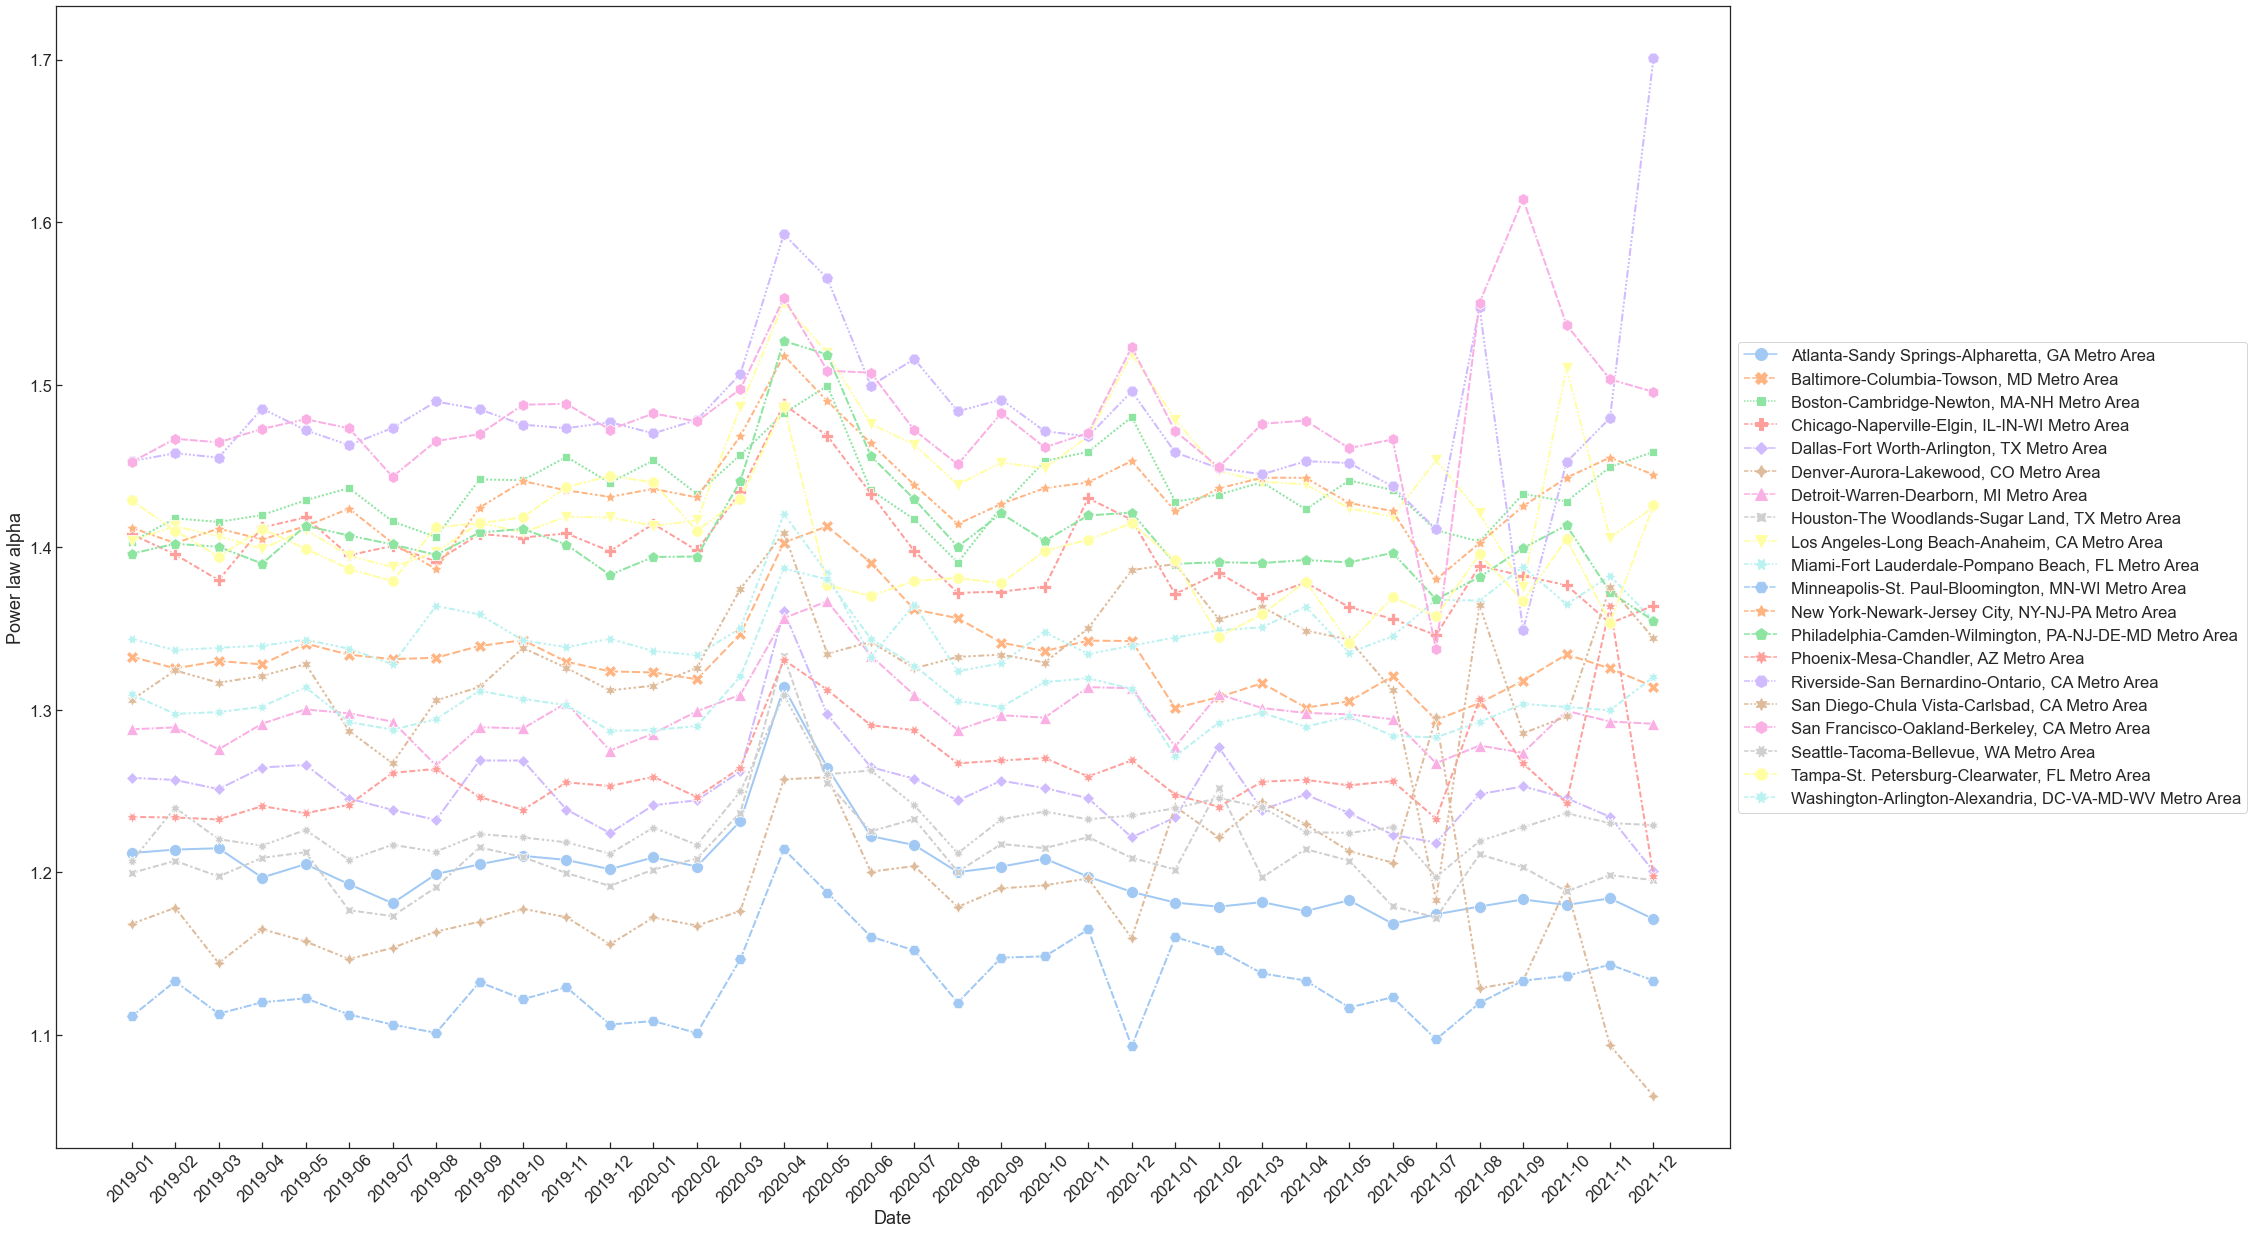

In [34]:
df_fit_bymsa.to_csv(folder+'/fit_by_msa.csv')
draw_fit_replot(df_fit_bymsa, "powerlaw_a", "Power law alpha", save_path=folder+'/by_msa_powerlaw_a.png')

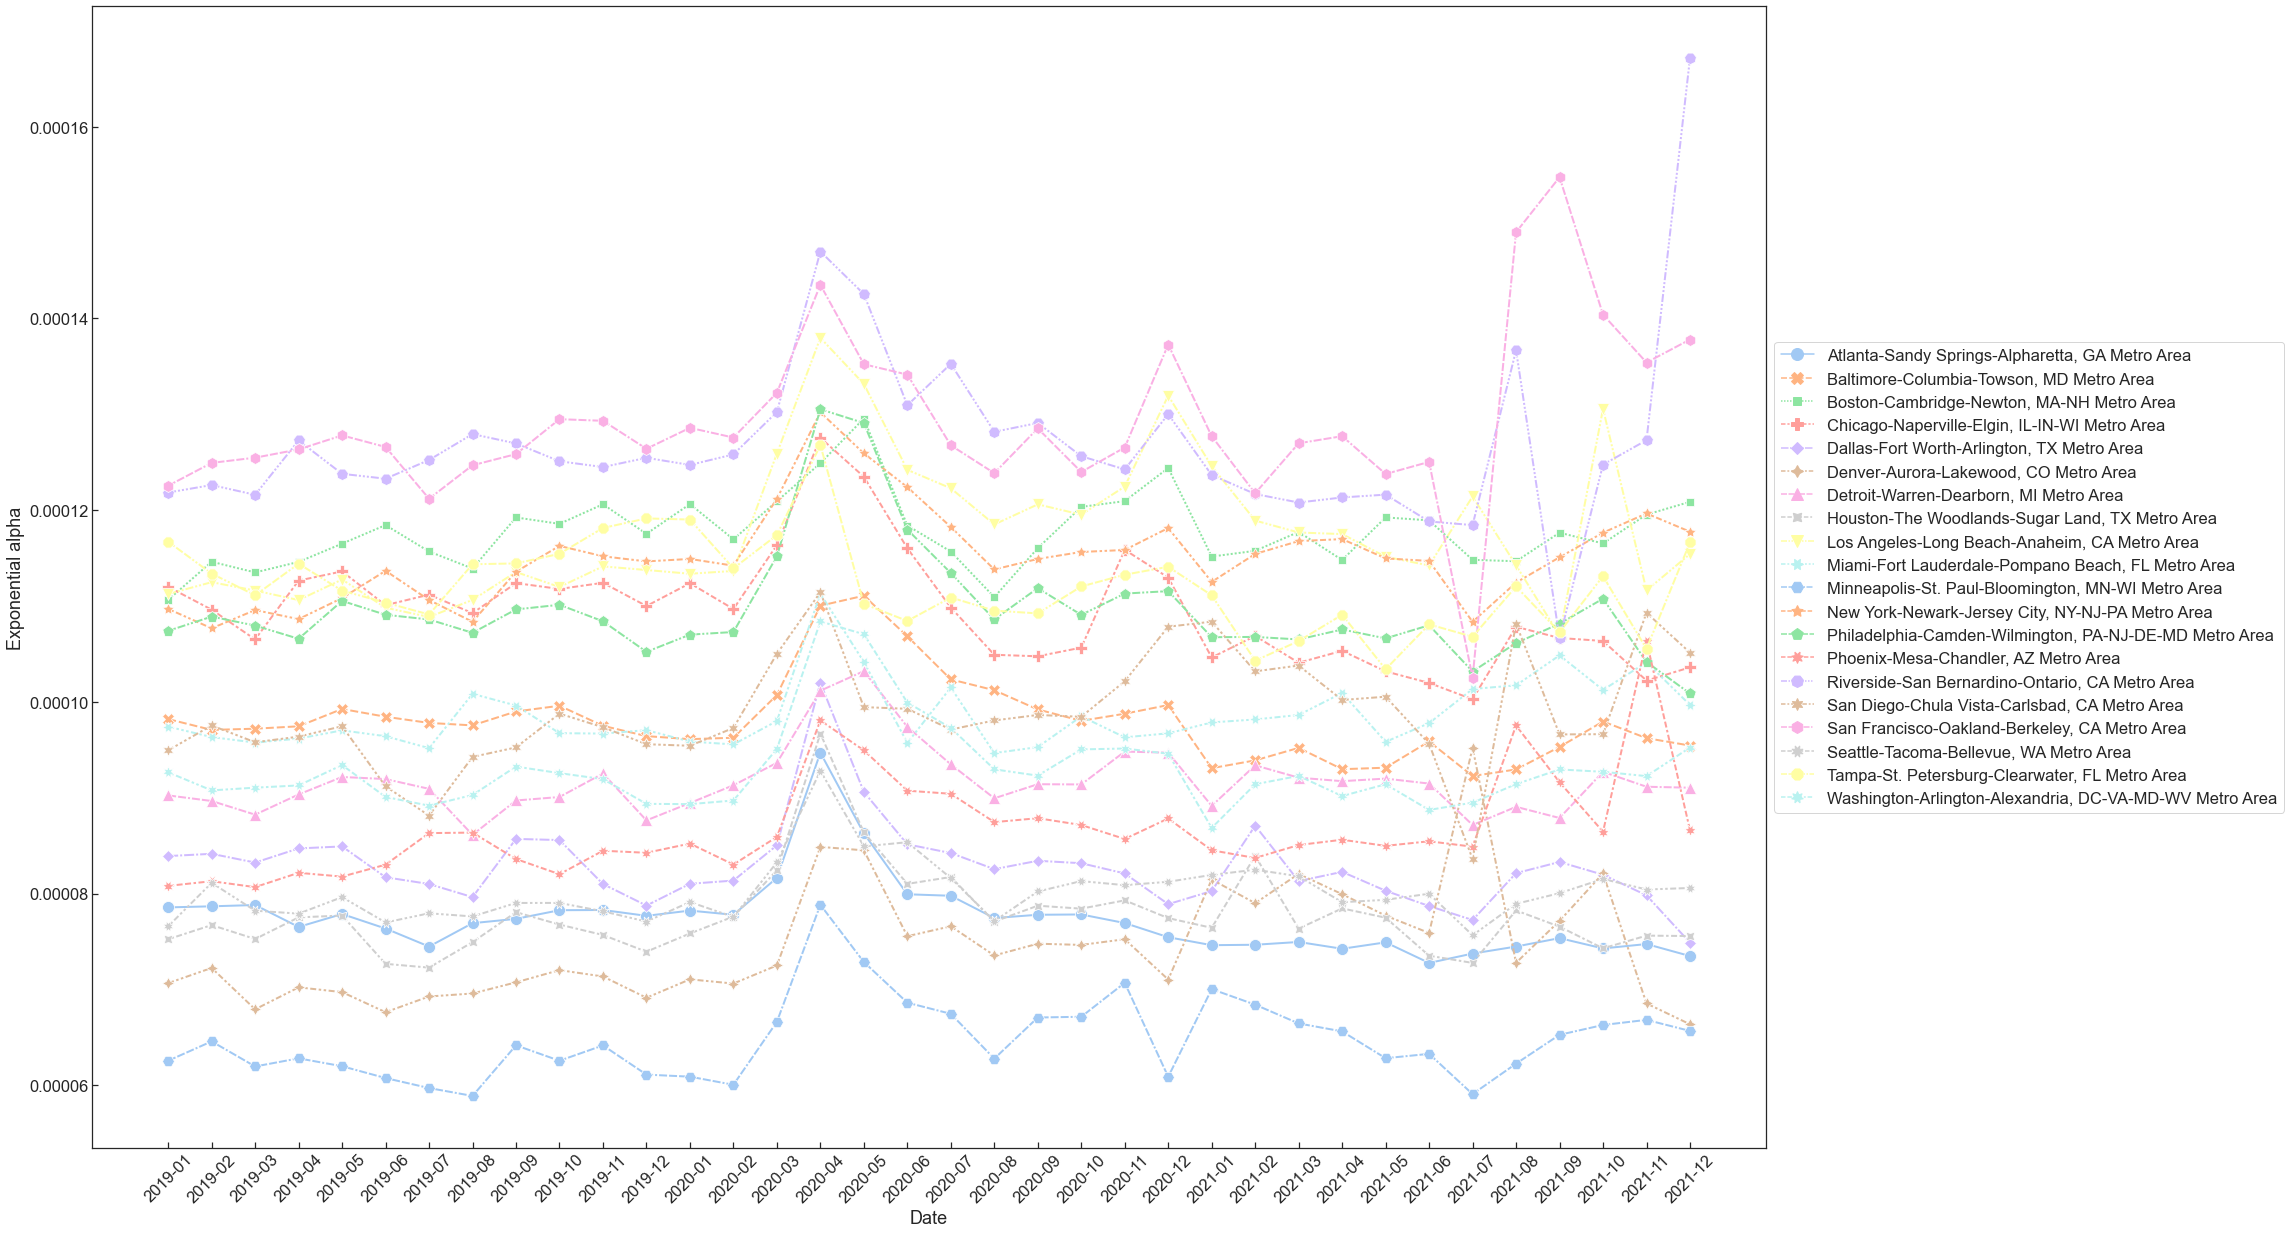

In [35]:
draw_fit_replot(df_fit_bymsa, "exponential_a", "Exponential alpha", save_path=folder+'/by_msa_exponential_a.png')

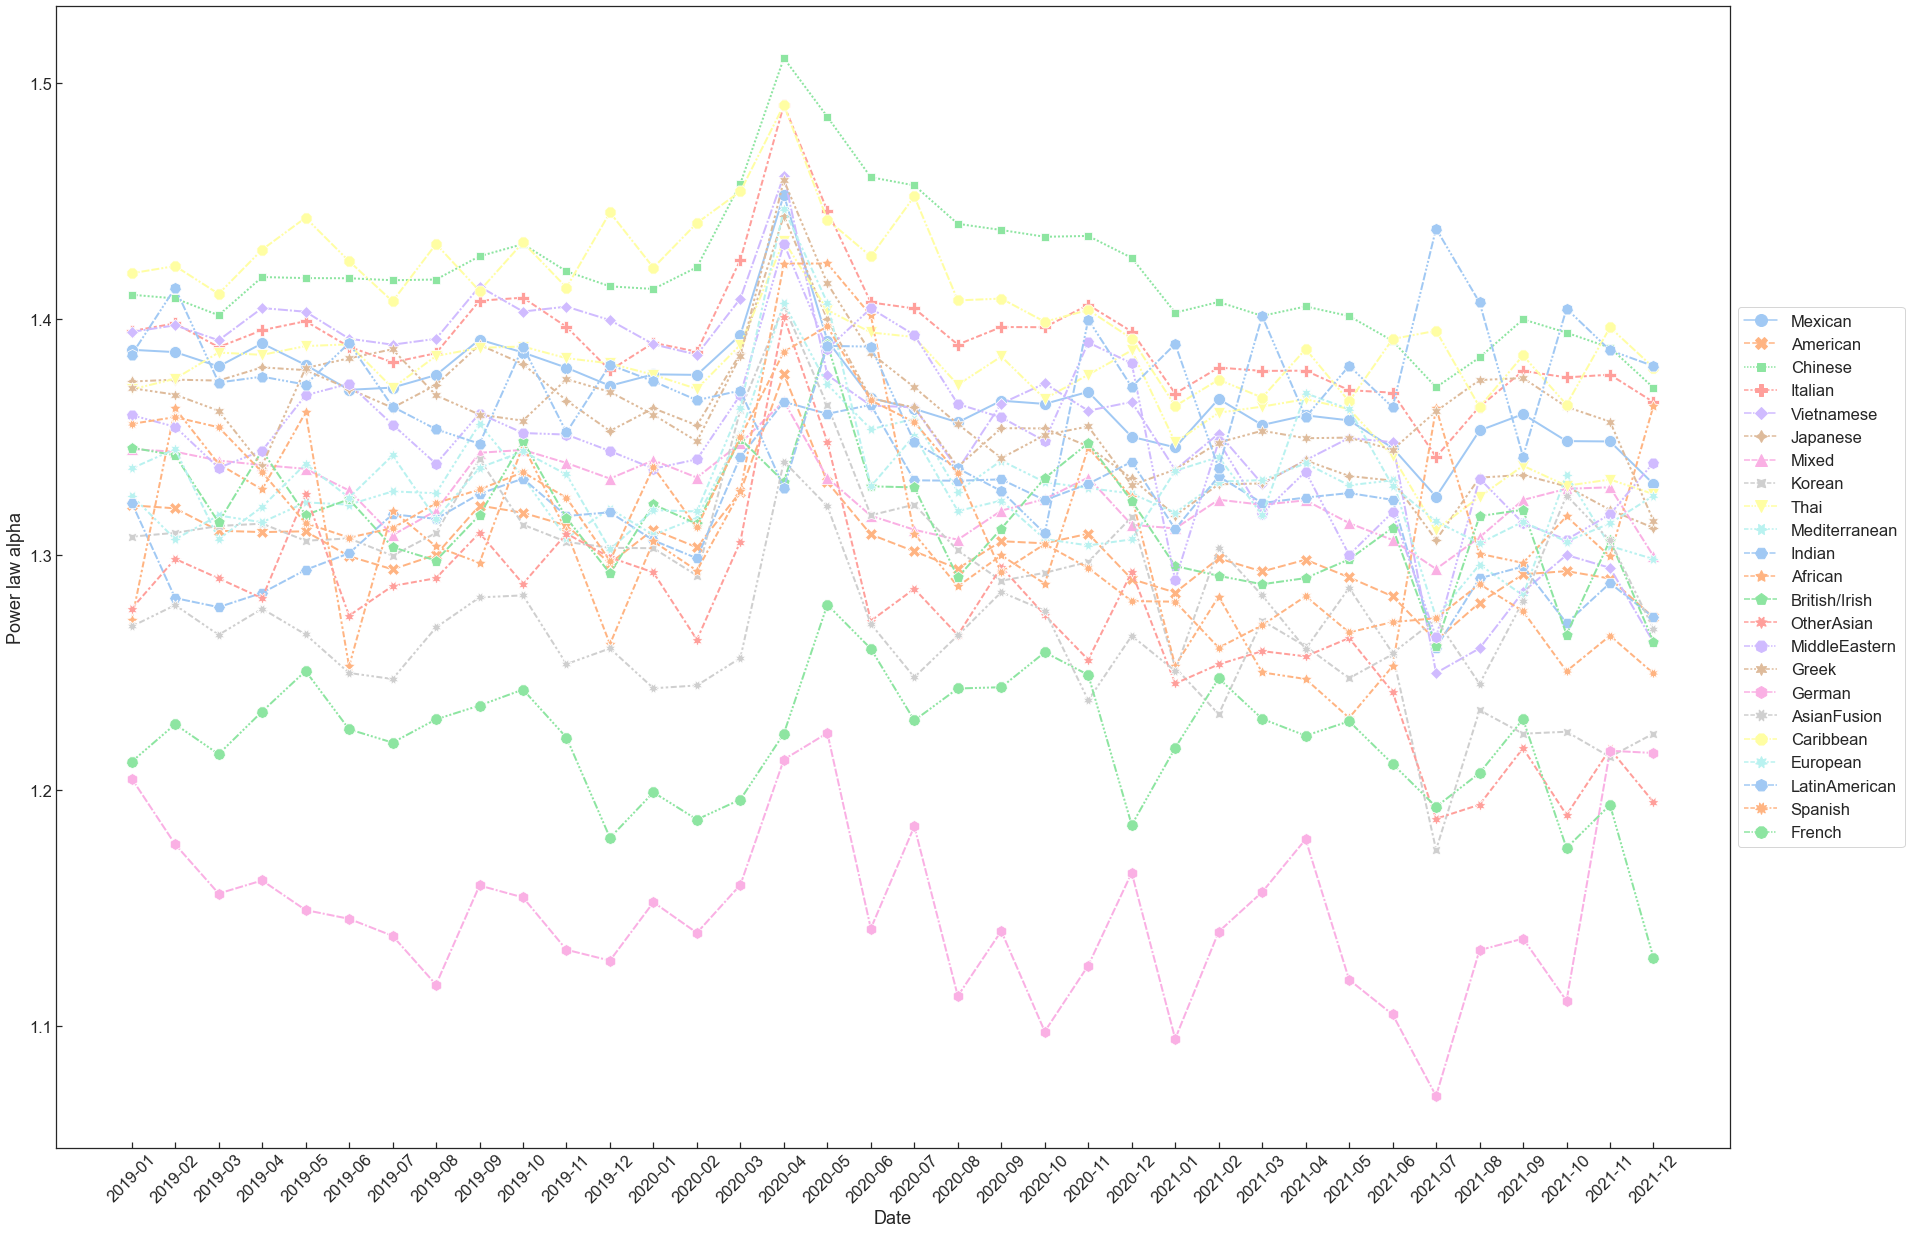

In [36]:
df_fit_bytype.to_csv(folder+'/fit_by_type.csv')
draw_fit_replot(df_fit_bytype, "powerlaw_a", "Power law alpha", save_path=folder+'/by_type_powerlaw_a.png')

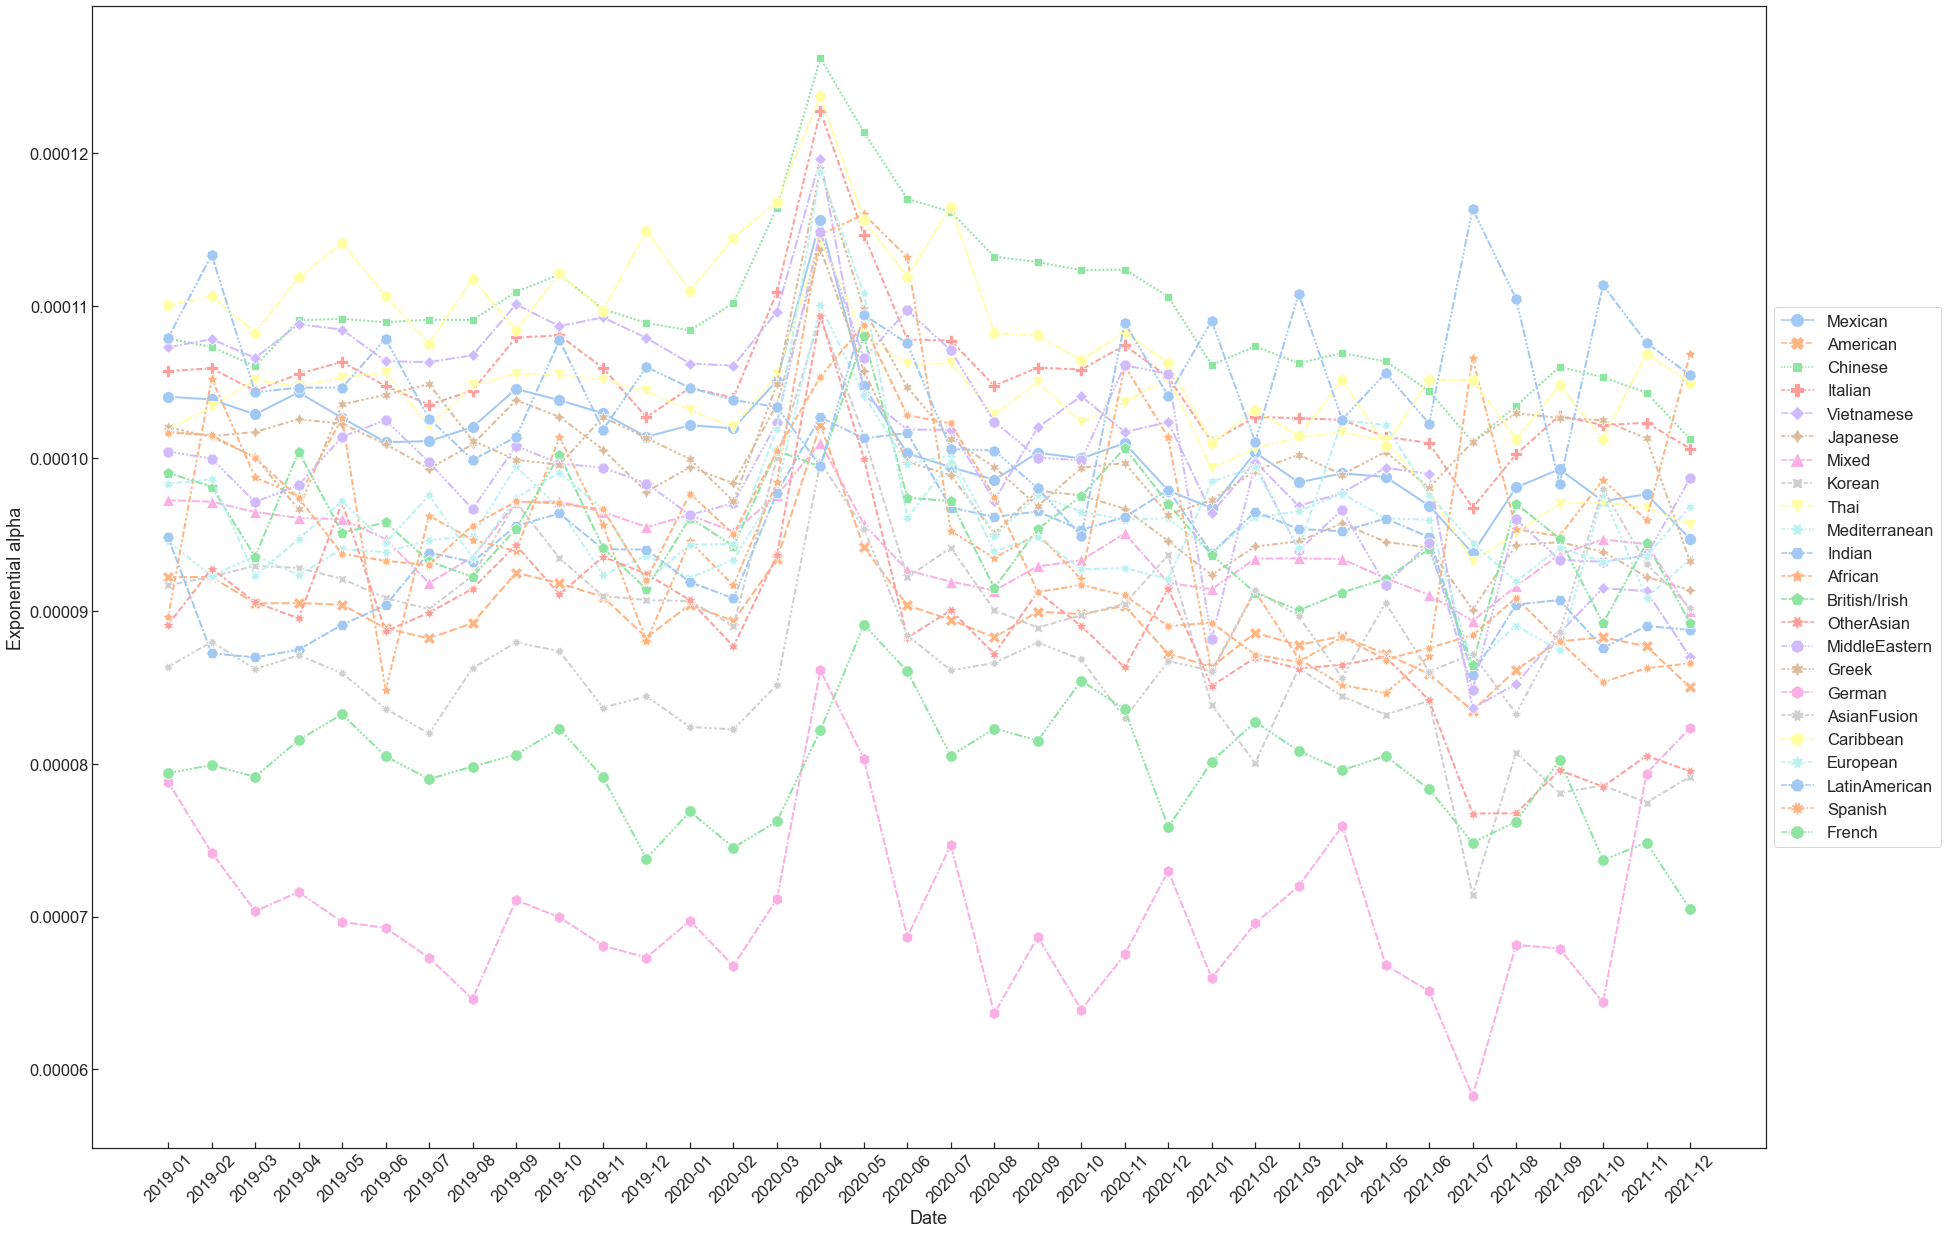

In [37]:
draw_fit_replot(df_fit_bytype, "exponential_a", "Exponential alpha", save_path=folder+'/by_type_exponential_a.png')